**import Libraries**

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle

**Data Collection and Processing**

In [113]:
data = pd.read_csv("weather_data.csv")
# remove extra spaces in each columnabs
data.columns.str.strip()
print("Data Info:")
data.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             311 non-null    object 
 1   avg_temperature  296 non-null    float64
 2   humidity         296 non-null    float64
 3   avg_wind_speed   296 non-null    float64
 4   rain_or_not      311 non-null    object 
 5   cloud_cover      296 non-null    float64
 6   pressure         311 non-null    float64
dtypes: float64(5), object(2)
memory usage: 17.1+ KB


In [114]:
# check for number of missing values
data.isnull().sum()

date                0
avg_temperature    15
humidity           15
avg_wind_speed     15
rain_or_not         0
cloud_cover        15
pressure            0
dtype: int64

In [115]:
for col in ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

C:\Users\HP\AppData\Local\Temp\ipykernel_20668\2435746351.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_20668\2435746351.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

In [116]:
# map Rain to 1 and No Rain to 0
data['rain_or_not'] = data['rain_or_not'].map({"Rain" : 1, "No Rain" : 0})
data['rain_or_not'].unique()

array([1, 0])

**Exploratory Data Analysis (EDA)**

In [117]:
data['date'] = pd.to_datetime(data['date'])

In [118]:
data.shape

(311, 7)

In [119]:
sns.set(style="whitegrid")

In [120]:
data.describe()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
count,311,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,2023-06-05 00:00:00,26.041434,55.124267,7.545533,0.636656,49.877768,1001.059119
min,2023-01-01 00:00:00,15.000000,30.000000,0.069480,0.000000,0.321826,951.240404
25%,2023-03-19 12:00:00,20.493383,35.686194,3.711684,0.000000,25.955498,975.757545
50%,2023-06-05 00:00:00,27.177958,56.759806,7.326421,1.000000,50.725120,1001.938586
75%,2023-08-21 12:00:00,31.858688,71.978037,10.897166,1.000000,74.162107,1026.578884
max,2023-11-07 00:00:00,35.000000,90.000000,56.636041,1.000000,99.834751,1049.543752
std,NaN,6.640805,18.752991,5.214007,0.481738,28.299560,28.835595


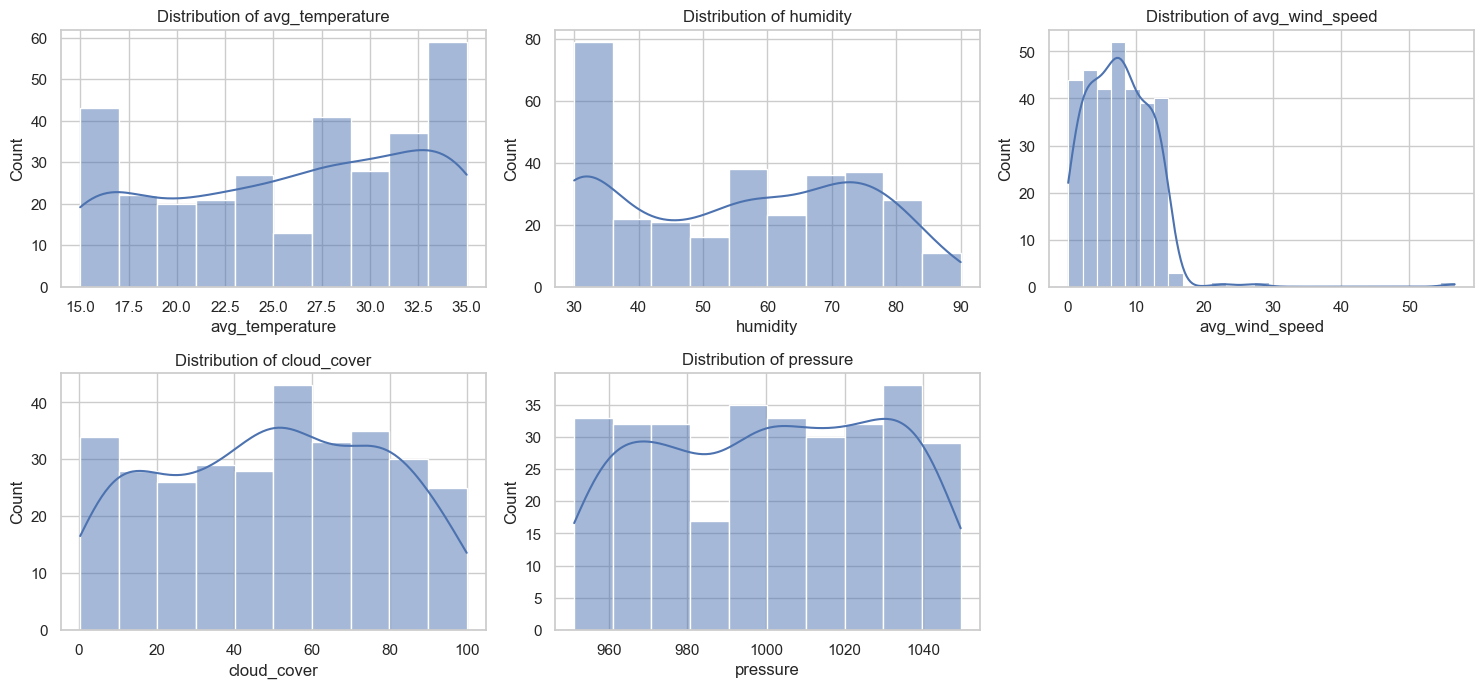

In [121]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure'], 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], kde= True)
    plt.title(f"Distribution of {column}")

plt.tight_layout()
plt.show()    

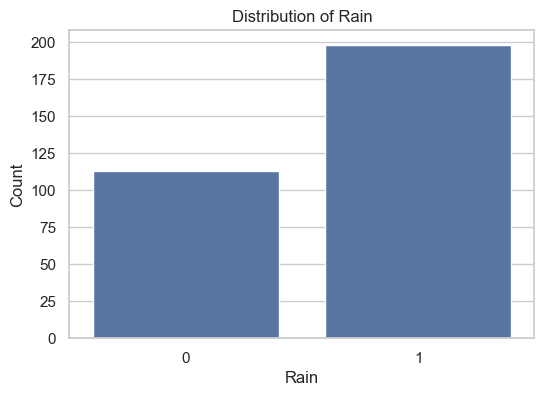

In [122]:
plt.figure(figsize=(6,4))
sns.countplot(x="rain_or_not", data = data)
plt.title("Distribution of Rain")
plt.xlabel("Rain")
plt.ylabel("Count")
plt.show()

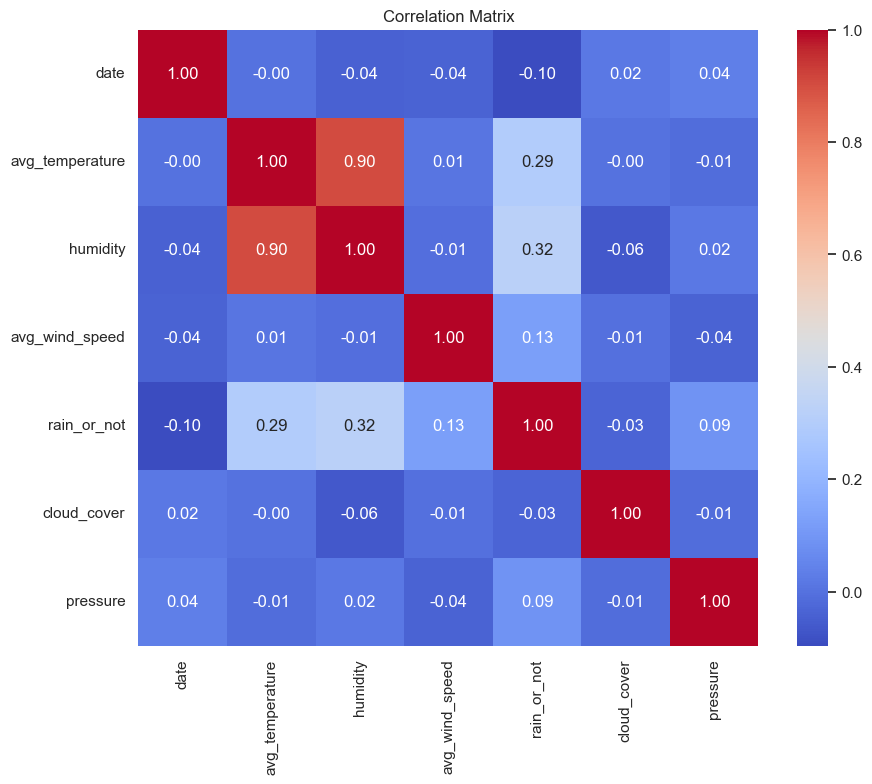

In [123]:
# correlation matrix
plt.figure(figsize= (10, 8))
sns.heatmap(data.corr(), annot= True, cmap= "coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

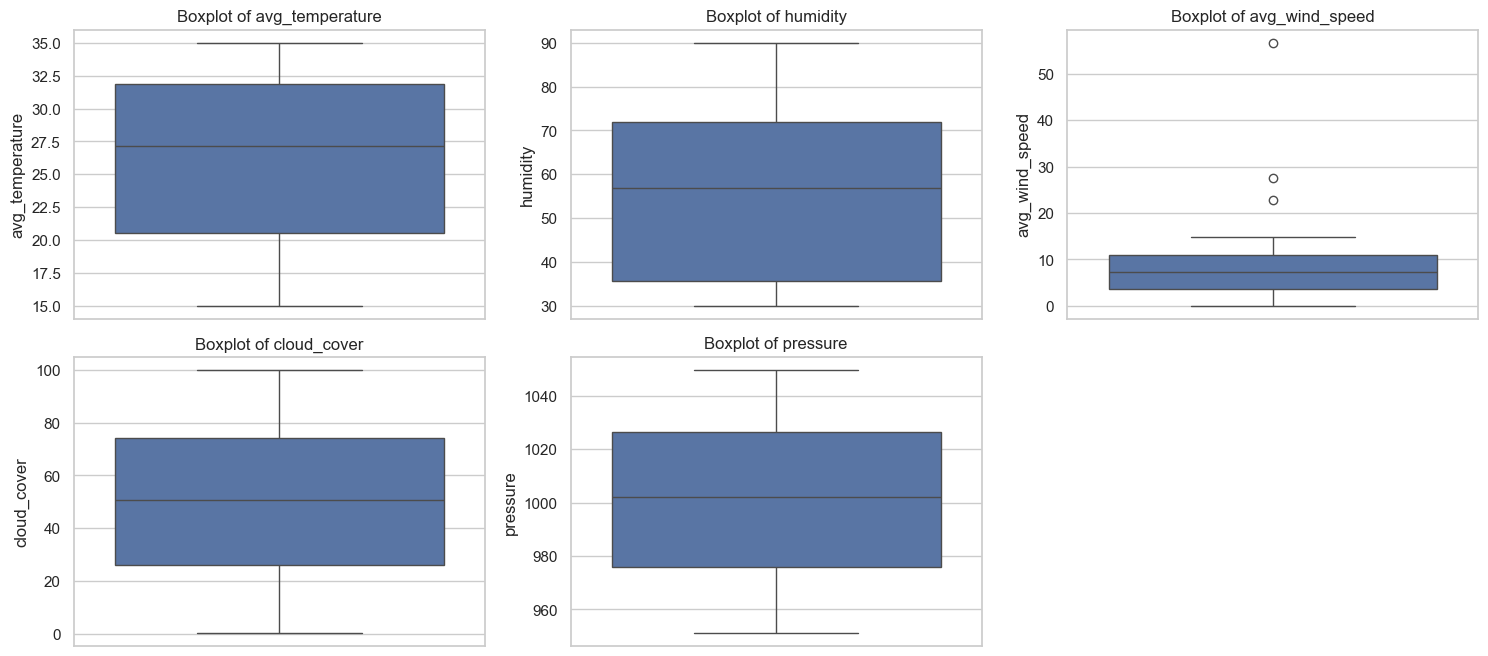

In [124]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure'], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data[column])
    plt.title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()    

In [125]:
# LIKE IN THE 55:00 time there are things that will drop highly corelated columns so in here the temp and the humidity is highly corealated so lests see whats need to happen

**Feature Engineering**

In [126]:
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day

In [127]:
data2 = data.copy()

In [128]:
print(data2)

          date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
0   2023-01-01        23.745401  46.140905        7.845981            1   
1   2023-01-02        30.030503  59.876587        5.382457            1   
2   2023-01-03        28.365224  51.464618       13.158008            1   
3   2023-01-04        27.550929  53.103799        5.886677            1   
4   2023-01-05        23.639303  57.826186       12.248992            1   
..         ...              ...        ...             ...          ...   
306 2023-11-03        22.072834  37.756910        4.729355            0   
307 2023-11-04        19.645885  42.190604        8.092369            0   
308 2023-11-05        23.884496  36.205508       11.860847            1   
309 2023-11-06        18.168418  34.785000        4.781288            0   
310 2023-11-07        19.389714  37.717416        9.388371            0   

     cloud_cover     pressure  month  day  
0      20.851051   992.965681      1    1  
1      93.0

In [129]:
# cyclical encoding for month
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# cyclical encoding for day
data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)

In [130]:
data.drop(columns=['month', 'day', 'date'], inplace=True)

In [131]:
# Create interaction features
data['temp_humidity_interaction'] = data['avg_temperature'] * data['humidity']
data['wind_temp_interaction'] = data['avg_wind_speed'] * data['avg_temperature']

In [132]:
data["rain_or_not"].value_counts()

rain_or_not
1    198
0    113
Name: count, dtype: int64

In [133]:
# upsampling will apply from here because there are too much of 1's for this rain_or_not column(Imbalace)
# separate majority and minority
df_majority = data[data["rain_or_not"] == 1]
df_minority = data[data["rain_or_not"] == 0]
print(df_majority.shape)
print(df_minority.shape)

(198, 12)
(113, 12)


In [134]:
# downsampling majority class to match minority count
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_minority_upsampled.shape

(198, 12)

In [135]:
df_upsampled = pd.concat([df_minority_upsampled, df_majority])
df_upsampled.shape

(396, 12)

In [136]:
# shuffling final dataframe
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop= True)

In [137]:
df_upsampled["rain_or_not"].value_counts()

rain_or_not
0    198
1    198
Name: count, dtype: int64

In [138]:
df_majority.isnull().sum()

avg_temperature              0
humidity                     0
avg_wind_speed               0
rain_or_not                  0
cloud_cover                  0
pressure                     0
month_sin                    0
month_cos                    0
day_sin                      0
day_cos                      0
temp_humidity_interaction    0
wind_temp_interaction        0
dtype: int64

In [139]:
# splitting the data into training data and test data
X = df_upsampled.drop(columns=["rain_or_not"])
Y = df_upsampled["rain_or_not"]
df_upsampled.head()

,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure,month_sin,month_cos,day_sin,day_cos,temp_humidity_interaction,wind_temp_interaction
0,15.421854,30.000000,8.708825,0,78.501654,996.393138,0.866025,-5.000000e-01,-0.101168,-0.994869,462.655634,134.306236
1,24.358469,55.448731,7.081004,1,15.016900,1003.302887,0.500000,-8.660254e-01,0.848644,0.528964,1350.646168,172.482417
2,23.886773,57.764299,56.636041,1,50.942213,965.124683,1.000000,6.123234e-17,0.394356,0.918958,1379.802689,1352.852254
3,15.494487,30.000000,12.583471,0,41.615400,1016.902234,1.000000,6.123234e-17,-0.790776,-0.612106,464.834620,194.974437
4,27.274189,44.284638,8.944048,1,57.187227,1010.065107,-0.866025,5.000000e-01,-0.848644,0.528964,1207.827603,243.941664


In [140]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [141]:
numerical_features = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure','month_sin', 'month_cos', 'day_sin', 'day_cos', 'temp_humidity_interaction', 'wind_temp_interaction']
scaler = StandardScaler()

X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

X_test[numerical_features] = scaler.transform(X_test[numerical_features])

**Using Different Models**

1. Logistic Regression

In [142]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
dt_model = DecisionTreeClassifier(random_state=42)

In [143]:
param_grid_lr = {
    "C": [0.1, 1, 10],              
    "penalty": ["l1", "l2"],       
    "solver": ["liblinear"]         
}

grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, cv=5, n_jobs=-1)

In [144]:
grid_search_lr.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']})

2. Random Forest

In [145]:
param_grid_rf = {
    "n_estimators": [50, 100],               
    "max_features": ["sqrt", "log2"],        
    "max_depth": [None, 10],                
    "min_samples_split": [2, 5],            
    "min_samples_leaf": [1, 2]             
}

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1)

In [146]:
grid_search_rf.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]})

3. XGBoost

In [147]:
param_grid_xgb = {
    "n_estimators": [50, 100],              
    "max_depth": [3, 6],                    
    "learning_rate": [0.1, 0.2],            
    "subsample": [0.8, 1.0],                
    "colsample_bytree": [0.8, 1.0]          
}

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1)

In [148]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
grid_search_xgb.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.1, 0.2], 'max_depth': [3, 6],
                         'n_estimators': [50, 100], 'subsample': [0.8, 1.0]})

4. Decision Trees

In [149]:
param_grid_dt = {
    "max_depth": [None, 5, 10],               
    "min_samples_split": [2, 5, 10],         
    "min_samples_leaf": [1, 2, 4],           
    "criterion": ["gini", "entropy"],       
    "max_features": ["sqrt", "log2", None]  
}

grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=5, n_jobs=-1)

In [150]:
grid_search_dt.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

**Model Evaluations**

In [151]:
def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    Y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    cv_scores = cross_val_score(model, X_train, Y_train, cv=5)
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
    print("Classification Report:")
    print(classification_report(Y_test, Y_pred))
    if Y_pred_proba is not None:
        print("ROC-AUC Score:", roc_auc_score(Y_test, Y_pred_proba) ,"\n")

In [152]:
print("Logistic Regression Performance:")
evaluate_model(grid_search_lr.best_estimator_, X_test, Y_test)
print("Random Forest Performance:")
evaluate_model(grid_search_rf.best_estimator_, X_test, Y_test)
print("XGBoost Performance:")
evaluate_model(grid_search_xgb.best_estimator_, X_test, Y_test) 
print("Decision Trees Performance:")
evaluate_model(grid_search_dt.best_estimator_, X_test, Y_test) 

Logistic Regression Performance:
Cross-validation scores: [0.671875   0.61904762 0.66666667 0.63492063 0.50793651]
Mean cross-validation score: 0.6200892857142857
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.70        45
           1       0.61      0.57      0.59        35

    accuracy                           0.65        80
   macro avg       0.64      0.64      0.64        80
weighted avg       0.65      0.65      0.65        80

ROC-AUC Score: 0.6888888888888888 

Random Forest Performance:
Cross-validation scores: [0.78125    0.82539683 0.77777778 0.77777778 0.82539683]
Mean cross-validation score: 0.7975198412698413
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        45
           1       0.77      0.77      0.77        35

    accuracy                           0.80        80
   macro avg       0.80      0.80      0.80        80

Choosed Random Forest from other ones

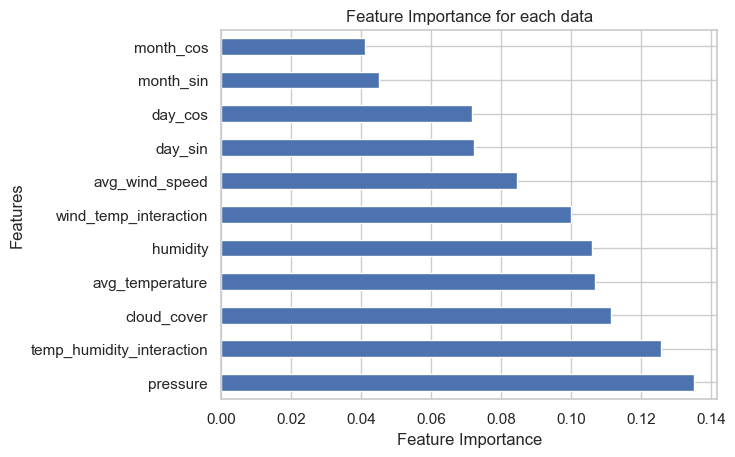

In [153]:
feature_importances = pd.Series(grid_search_rf.best_estimator_.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='barh')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for each data")
plt.show()

**Predictions**

In [154]:
feature_stats = {}
for feature in ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']:
    feature_stats[feature] = {
        'mean': data2[feature].mean(),
        'std': data2[feature].std(),
        'min': data2[feature].min(),
        'max': data2[feature].max(),
        'trend': data2[feature].diff().mean()  
    }

In [155]:
user_input = {
    'avg_temperature': 30.5,  
    'humidity': 79.0,         
    'avg_wind_speed': 11.829,    
    'cloud_cover': 39.0,      
    'pressure': 974.0        
}

In [156]:
future_dates = pd.date_range(start="2023-1-08", periods=21, freq='D')  # Replace with user-provided start date
future_data = pd.DataFrame(index=range(1, 22)) 
future_data['date'] = future_dates

In [157]:
last_value = user_input.copy()

for feature in ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']:
    future_data[feature] = np.nan 
    for i in range(21):
        next_value = last_value[feature] + feature_stats[feature]['trend'] + \
                     np.random.normal(0, feature_stats[feature]['std'] / 2)  
        next_value = max(feature_stats[feature]['min'], min(feature_stats[feature]['max'], next_value))
        future_data.at[i + 1, feature] = next_value  
        last_value[feature] = next_value

print("\nGenerated Features for the Next 21 Days:")
print(future_data)


Generated Features for the Next 21 Days:
         date  avg_temperature   humidity  avg_wind_speed  cloud_cover  \
1  2023-01-08        35.000000  73.446440       12.199396    49.011420   
2  2023-01-09        35.000000  76.443855        9.953701    47.402376   
3  2023-01-10        35.000000  81.998628        3.624270    22.871575   
4  2023-01-11        32.693725  79.164646        4.997617    42.958170   
5  2023-01-12        35.000000  71.802086        4.322865    16.971587   
6  2023-01-13        32.489693  71.629817        5.811288     7.953823   
7  2023-01-14        35.000000  64.804576        3.141861     0.321826   
8  2023-01-15        35.000000  63.025678        1.121202    16.936123   
9  2023-01-16        33.416063  81.095202        0.069480    32.054923   
10 2023-01-17        35.000000  79.248647        0.687938    42.396428   
11 2023-01-18        34.643482  77.714137        4.515269    43.215020   
12 2023-01-19        35.000000  74.404071        1.761471    62.509419

In [158]:
future_data["month"] = future_data["date"].dt.month
future_data["day"] = future_data["date"].dt.day

# cyclical encoding for month
future_data['month_sin'] = np.sin(2 * np.pi * future_data['month'] / 12)
future_data['month_cos'] = np.cos(2 * np.pi * future_data['month'] / 12)

# cyclical encoding for day
future_data['day_sin'] = np.sin(2 * np.pi * future_data['day'] / 31)
future_data['day_cos'] = np.cos(2 * np.pi * future_data['day'] / 31)

future_data.drop(columns=['month', 'day', 'date'], inplace=True)

future_data['temp_humidity_interaction'] = future_data['avg_temperature'] * future_data['humidity']
future_data['wind_temp_interaction'] = future_data['avg_wind_speed'] * future_data['avg_temperature']

In [160]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Replace X_train with your training data

numerical_features = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure','month_sin', 'month_cos', 'day_sin', 'day_cos', 'temp_humidity_interaction', 'wind_temp_interaction']
future_X = future_data[numerical_features]
future_X_scaled = scaler.transform(future_X)

future_predictions = grid_search_rf.best_estimator_.predict_proba(future_X_scaled)[:, 1]
future_data['rain_probability'] = future_predictions
future_data['rain_or_not'] = (future_predictions >= 0.5).astype(int)

print("\nPredictions for the Next 21 Days:")
print(future_data[['rain_probability', 'rain_or_not']])


Predictions for the Next 21 Days:
    rain_probability  rain_or_not
1           0.778976            1
2           0.768976            1
3           0.768976            1
4           0.748976            1
5           0.738976            1
6           0.738976            1
7           0.963810            1
8           0.738976            1
9           0.704976            1
10          0.724976            1
11          0.738976            1
12          0.748976            1
13          0.731476            1
14          0.731476            1
15          0.728976            1
16          0.728976            1
17          0.724976            1
18          0.717476            1
19          0.717476            1
20          0.727476            1
21          0.724976            1
